In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import decimate
from scipy.signal import resample
from tqdm import tqdm as progress
from scipy.interpolate import interp1d,CubicSpline

In [2]:
df = pd.read_pickle('tod.pkl')

In [137]:
class CM:
    
    def __init__(self,df,dfreq):
        self.bolo_time = df['bolotime']*3600.*24
        self.df_tod = df.loc[:, df.columns!='bolotime']#self.detrend_df(df.loc[:, df.columns!='bolotime'])
        self.bololist = list(self.df_tod.columns)
        self.dfreq = dfreq
        self.n = self.search_n
        self.bolo_time_ds = self.downsample_arr(self.bolo_time)
        
        ini_sr = self.sample_rate(self.bolo_time)
        final_sr = self.sample_rate(self.bolo_time_ds)
        print(f"Sampling rate will be downsampled from {ini_sr:.2f} to {final_sr:.2f}")
        
    @property
    def search_n(self):
        """
        n = length of intial array/ downsampling factor
        downsampling factor = initial sampling rate/ desired sampling rate
        
        Above 'n' is just a rough estimate. To get a more precise 'n'
        this function minimize the difference between the desired sampling
        rate and the one which is calcualted
        
        TODO: this minimize the values in one direction, which is not good.
        """
        n0 = int(len(self.bolo_time)/(self.sample_rate(self.bolo_time)/self.dfreq))
        init_sr = self.sample_rate(self.bolo_time)
        n0_sr = self.sample_rate(self.downsample_arr(self.bolo_time,n0))
        assert (n0_sr- self.dfreq) > 0
        dif = np.abs(self.dfreq - n0_sr)
        i = 1
        while (dif > 0.01) and (i < 1000):
            n = n0 - i
            present_sr = self.sample_rate(self.downsample_arr(self.bolo_time,n))
            future_sr = self.sample_rate(self.downsample_arr(self.bolo_time,n-1))
            dif = np.abs(self.dfreq - present_sr)
            i+=1
            
            # This line is to avoid screwing up the overestimation situation
            if np.abs(self.dfreq-future_sr) > np.abs(self.dfreq-present_sr):
                break
        return n

        
    
    @staticmethod
    def sample_rate(time):
        """
        Sample rate = 1/dt
        """
        return 1/np.mean(np.diff(time))
    
    def downsample_arr(self,arr,n=None):
        """
        Downsample a single array
        """
        if n is None:
            n = self.n
        #return decimate(decimate(arr,2),2)
        #return downsample(arr)
        return resample(arr,n)
    
    def detrend_arr(self,arr):
        return arr - np.mean(arr)
    
    def detrend_df(self,df):
        progress.pandas(desc='Detrending the TODs')
        return df.progress_apply(self.detrend_arr)
    
    def downsample_df(self,df):
        """
        Downsample a pandas dataframe
        """
        progress.pandas(desc='Downsampling the TODs')
        return df.progress_apply(self.downsample_arr)
    
    def eigendecom(self,cov):
        """
        Cov = V.E.V^T
        """
        E,V = np.linalg.eig(cov)
        E[np.isnan(E)] = 0.
        idx = np.argsort(-E)
        return E[idx], V[:, idx]
    
    def create_nmodes(self,cov,nmodes,V,signal):
        """
        Common modes
        """
        V_n = V[:, :nmodes]
        modes = np.dot(V_n.transpose(), signal)
        return V_n, modes
    
    def cm_subtract(self,nmodes):
        """
        Subtract the common modes after interpolation
        
        """
        df_tod_ds = self.downsample_df(self.df_tod)
        signal_ds = df_tod_ds.values.T
        cov = np.cov(signal_ds)
        E,R = self.eigendecom(cov)
        R_n,modes = self.create_nmodes(cov,nmodes,R,signal_ds)
        
        signal_fs = self.df_tod.values.T
        signal_sub = np.zeros_like(signal_fs)

        for i in progress(range(len(E)),desc="Subtracting Common Modes",unit='detector'):
            modes_interp = interp1d(self.bolo_time_ds,np.dot(R_n[i, :], modes).real,fill_value="extrapolate")
            #modes_interp = CubicSpline(self.bolo_time_ds,np.dot(R_n[i, :], modes).real,extrapolate='periodic')
            signal_sub[i] = signal_fs[i] - modes_interp(self.bolo_time)
            
        return self.dataframe(signal_sub,self.bololist)
    
    def cm_subtract_full(self,nmodes):
        """
        Subtract the common modes after interpolation
        
        """
        signal_ds = self.df_tod.values.T
        cov = np.cov(signal_ds)
        E,R = self.eigendecom(cov)
        R_n,modes = self.create_nmodes(cov,nmodes,R,signal_ds)
        
        signal_fs = self.df_tod.values.T
        signal_sub = np.zeros_like(signal_fs)

        for i in progress(range(len(E)),desc="Subtracting Common Modes",unit='detector'):
            
            signal_sub[i] = signal_fs[i] - np.dot(R_n[i, :], modes).real
            
        return self.dataframe(signal_sub,self.bololist)
    
    def dataframe(self,signal,col):
        df = pd.DataFrame(signal.T)
        df.columns = col
        return df



def downsample(x):
    x = np.array(x)
    
    q = 20
    o = 0
    n = 256 + 1
    window = ('kaiser',6)
    aafilter = scipy.signal.firwin(n,1.0/q,window=window)

    xtype = x.dtype

    padding_first = np.ones(n)*x[0]
    padding_last = np.ones(n)*x[-1]
    u = np.concatenate((padding_first,x,padding_last))
    xaa = np.convolve(aafilter,u,mode='same')
    xaaclip = xaa[n:-n]
    xds = xaaclip[o::q]
    return xds

In [152]:
c = CM(df,85)

Sampling rate will be downsampled from 152.59 to 84.99


Downsampling the TODs: 100%|██████████| 361/361 [00:00<00:00, 1339.00it/s]


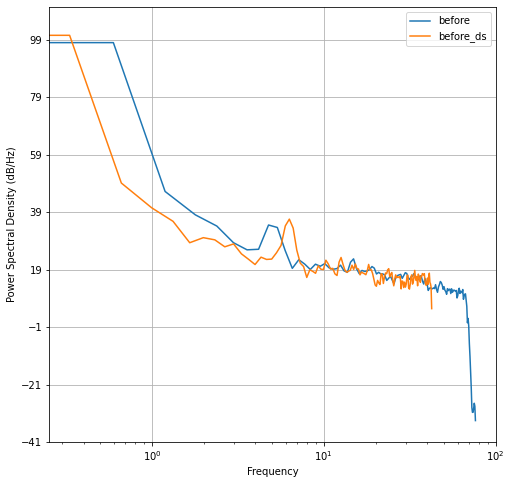

In [155]:
idx = 1
rm = 4
plt.figure(figsize=(8,8))
NUL = plt.psd(c.df_tod[c.bololist[idx]],Fs=152.59,label='before',)
NUL = plt.psd(c.downsample_df(c.df_tod)[c.bololist[idx]],Fs=84.9,label='before_ds',)
#NUL = plt.psd(c.cm_subtract_full(rm)[c.bololist[idx]],Fs=152,label='after_full')
#NUL = plt.psd(c.cm_subtract(rm)[c.bololist[idx]],Fs=152,label='after_partial')
plt.xscale('log')
plt.legend()

In [78]:
np.where(np.diff(downsample(c.bolo_time)) <0)

(array([], dtype=int64),)

In [79]:
c.sample_rate(downsample(c.bolo_time))

38.155995085341004

Subtracting Common Modes:   0%|          | 0/361 [00:00<?, ?detector/s]<ipython-input-54-45529a8ab15a>:109: ComplexWarning: Casting complex values to real discards the imaginary part
  signal_sub[i] = signal_fs[i] - modes_interp(self.bolo_time)
Subtracting Common Modes: 100%|██████████| 361/361 [00:00<00:00, 2037.54detector/s]


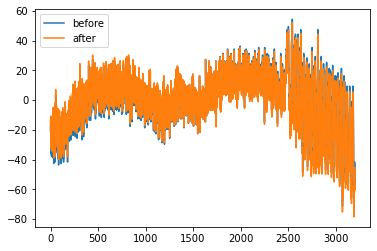

In [68]:
to = c.cm_subtract(1)[c.bololist[idx]]
plt.plot(c.df_tod[c.bololist[idx]]-np.mean(c.df_tod[c.bololist[idx]]),label='before')
plt.plot(to - np.mean(to),label='after')
plt.legend()

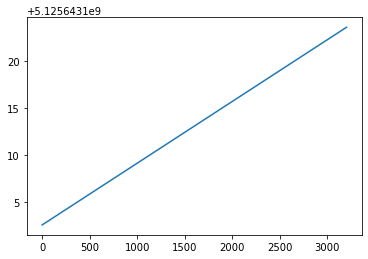

In [11]:
plt.plot(c.bolo_time)

In [10]:
c.bolo_time_ds

array([5.12564198e+09, 5.12564197e+09, 5.12564197e+09, 5.12564197e+09,
       5.12564197e+09, 5.12564197e+09, 5.12564197e+09, 5.12564197e+09,
       5.12564197e+09, 5.12564197e+09, 5.12564197e+09, 5.12564197e+09,
       5.12564197e+09, 5.12564197e+09, 5.12564197e+09, 5.12564197e+09,
       5.12564198e+09, 5.12564198e+09, 5.12564198e+09, 5.12564198e+09,
       5.12564198e+09, 5.12564198e+09, 5.12564198e+09, 5.12564198e+09,
       5.12564198e+09, 5.12564198e+09, 5.12564198e+09, 5.12564198e+09,
       5.12564198e+09, 5.12564198e+09, 5.12564198e+09, 5.12564198e+09,
       5.12564198e+09, 5.12564198e+09, 5.12564198e+09, 5.12564198e+09,
       5.12564198e+09, 5.12564198e+09, 5.12564198e+09, 5.12564198e+09,
       5.12564198e+09, 5.12564198e+09, 5.12564198e+09, 5.12564198e+09,
       5.12564198e+09, 5.12564199e+09, 5.12564199e+09, 5.12564199e+09,
       5.12564199e+09, 5.12564199e+09, 5.12564199e+09, 5.12564199e+09,
       5.12564199e+09, 5.12564199e+09, 5.12564199e+09, 5.12564199e+09,
      